###### Minimalna/Maksymalna wartość w przedziale
https://www.youtube.com/watch?v=xztU7lmDLv8

# Implementacja drzewa przedziałowego
### (Omawiana w dwóch pierwszych nagraniach wyżej)

### Pomocnicze źródła

###### Tworzenie zbalansowanego drzewa binarnego z tablicy posortowanych wartości
https://www.techiedelight.com/construct-balanced-bst-given-keys/

### Pomocniczy kod

In [1]:
def binary_tree_string(tree_root, *, fn=lambda node: node.val):
    if not tree_root: return ''

    # Store data from a tree
    data = []
    lvl_nodes = [tree_root]
    just = 1

    while True:
        if not lvl_nodes: break

        curr_row = []
        branches = []
        next_nodes = []

        if not any(lvl_nodes):
            break

        for node in lvl_nodes:
            if not node:
                curr_row.append('')
                branches.extend([' ', ' '])
                next_nodes.extend([None, None])
            else:
                val = str(fn(node))
                just = max(len(val), just)
                curr_row.append(val)

                if node.left:
                    next_nodes.append(node.left)
                    branches.append('/')
                else:
                    next_nodes.append(None)
                    branches.append(' ')

                if node.right:
                    next_nodes.append(node.right)
                    branches.append('\\')
                else:
                    next_nodes.append(None)
                    branches.append(' ')

        data.append((curr_row, branches))
        lvl_nodes = next_nodes

    begin_sep = sep = 3 if just % 2 else 2
    data_iter = iter(data[::-1])
    result = [''] * (len(data) * 2 - 1)
    result[-1] = (' ' * sep).join(val.center(just) for val in next(data_iter)[0])

    # Format the tree string
    for i, (values, branches) in enumerate(data_iter):
        mul = 2 * i + 1
        # Values
        indent = (2 ** (i + 1) - 1) * (just + begin_sep) // 2
        sep = 2 * sep + just
        result[-(mul + 2)] = f"{' ' * indent}{(' ' * sep).join(val.center(just) for val in values)}"
        # Branches
        branch_indent = (3 * indent + just) // 4
        branches_row = []
        d_indent = indent - branch_indent
        branches_sep = ' ' * (2 * (d_indent - 1) + just)
        for i in range(0, len(branches), 2):
            branches_row.append(f"{branches[i]}{branches_sep}{branches[i + 1]}")
        result[-(mul + 1)] = f"{' ' * branch_indent}{(' ' * (sep - 2 * d_indent)).join(branches_row)}"

    return '\n'.join(result)

## Implementacja #1
#### (Drzewo omawiane na wykładzie)
##### (Bez sprawdzania, czy dodawany przedział był już wcześniej dodany)

### Uwagi

Jeżeli kilka razy dodamy ten sam przedział do drzewa, zostanie on dodany wielokrotnie (nie jest sprawdzane to, czy dany przedział został już wcześniej dodany).
<br><br>
Poniższa implementacja sprawdza, czy przedział da się umieścić w drzewie. Jeżeli nie, wzbudzony zostaje wyjątek.

### Złożoność

###### Obliczeniowa
$ O(n \cdot log(n)) $ - budowanie drzewa przedziałowego (sortowanie końców przedziałów odbywa się w tym czasie), <br>
$ O(log(n)) $ - wstawianie pojedynczego przedziału do drzewa, <br>
$ O(log(n) + k) $ - wypisywanie wszystkich przedziałów, w których zawiera się wskazana liczba, gdzie $ n $ - liczba węzłów w drzewie, $ k $ - liczba przedziałów, jakie otrzymamy jako rezultat, <br>
$ O(n) $ - usuwanie przedziału (możliwe, że wszystkie przedziały trafiły na jedną listę i trzeba wszystkie przesunąć)
###### Pamięciowa
$ O(n \cdot log(n)) $ - w drzewie maksymalnie znajdzie się $ log(n) $ kopii każdego z przedziałów, a więc łącznie będzie tyle przedziałów
<br><br>
$ n $ - liczba węzłów w drzewie

### Kod

In [2]:
class ITNode:
    def __init__(self, key, span):
        self.key = key
        self.span = span
        self.parent = None
        self.intervals = []
        self.left = self.right = None
        

class IntervalTree:
    def __init__(self, spans, insert_spans=False):
        self.root = self.build_tree(self.get_coordinates(spans))
        if insert_spans:
            for span in spans:
                self.insert(span)
        
    def insert(self, span):
        nodes_list = self._get_nodes(span)
        
        if not nodes_list:
            raise ValueError(f"Span '{span}' cannot be inserted")
            
        for node in nodes_list:
            node.intervals.append(span)
            
    def remove(self, span):
        nodes_list = self._get_nodes(span)
        error = not nodes_list
        try:
            for node in nodes_list:
                node.intervals.remove(span)  # O(n)
        except ValueError:
            error = True
        if error:
            raise ValueError(f"Span '{span}' not in {self.__class__.__name__}")
        
    def query(self, val):
        intervals = []
        
        def recur(node):
            if node.span[0] <= val <= node.span[1]:
                if node.key:
                    if val <= node.key:  # change to < if want sharp inequality
                        recur(node.left)
                    elif val >= node.key:  # change to > if want sharp inequality
                        recur(node.right)
                intervals.extend(node.intervals)
                    
        recur(self.root)
        return intervals
        
    @staticmethod
    def build_tree(values):
        inf = float('inf')
        
        def recur(i, j, l=-inf, r=inf, parent=None):
            # Create a leaf node
            if i > j: 
                node = ITNode(None, (l, parent.key) if l != parent.key else (parent.key, r))
                node.parent = parent
                return node
            
            mid = (i + j) // 2
            root = ITNode(values[mid], (l, r))
            root.parent = parent
            root.left  = recur(i, mid - 1, l, values[mid], root)
            root.right = recur(mid + 1, j, values[mid], r, root)
            
            return root
        
        return recur(0, len(values) - 1)
        
    @staticmethod
    def get_coordinates(spans):
        # Create an array of sorted begin-end spans coordinates
        A = [c for span in spans for c in span]
        A.sort()
        # Filter out repeated values
        B = [A[0]]
        for i in range(1, len(A)):
            if A[i] != A[i - 1]:
                B.append(A[i])
        return B
    
    def _get_nodes(self, span):
        l, r = span
        is_valid = True
        nodes_list = []
        
        def recur(node):
            # If a node represents a span which is contained in the inserted
            # span, we will add this span to a node's intervals list
            if l <= node.span[0] and node.span[1] <= r:
                nodes_list.append(node)
            # If the span inserted is no valid span
            elif node.key is None:
                nonlocal is_valid
                is_valid = False
                return
            # If the current node's key value splits inserted span, we have
            # to go left and right in a tree
            elif l < node.key < r:
                recur(node.left)
                recur(node.right)
            # If the current node's key is on the right side of the inserted
            # span, we have to go left
            elif r <= node.key:
                recur(node.left)
            # If the current node's key is on the left side, we have to go
            # right
            elif node.key <= l:
                recur(node.right)
            
        recur(self.root)
        return nodes_list if is_valid else []

###### Kilka testów

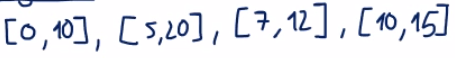

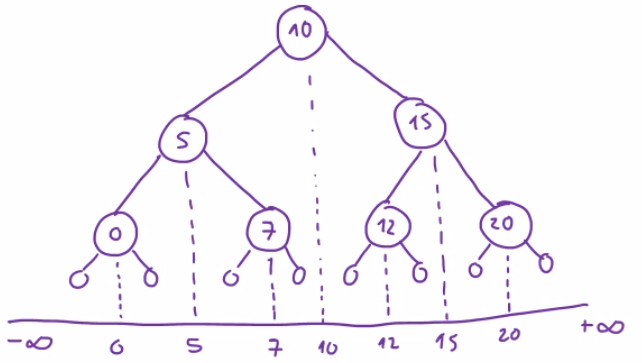

In [3]:
S = [[0, 10], [5, 20], [7, 12], [10, 15]]

it = IntervalTree(S, True)

In [4]:
print(binary_tree_string(it.root, fn=lambda node: node.key))

                      10 
                /            \
          5                       15 
       /      \                /      \
    0           7           12          20 
   /  \        /  \        /  \        /  \
None  None  None  None  None  None  None  None


In [5]:
print(binary_tree_string(it.root, fn=lambda node: node.span))

                                                 (-inf, inf)
                                       /                             \
                      (-inf, 10)                                              (10, inf) 
                  /               \                                       /               \
        (-inf, 5)                    (5, 10)                     (10, 15)                   (15, inf) 
        /       \                   /       \                   /       \                   /       \
 (-inf, 0)       (0, 5)        (5, 7)       (7, 10)       (10, 12)      (12, 15)      (15, 20)     (20, inf) 


In [6]:
def dfs(node):
    print(f'Node key: {str(node.key).ljust(4)} \tparent: {str(node.parent.key if node.parent else None).ljust(4)} \tintervals: {node.intervals}')
    if node.left:
        dfs(node.left)
    if node.right:
        dfs(node.right)
        
dfs(it.root)

Node key: 10   	parent: None 	intervals: []
Node key: 5    	parent: 10   	intervals: []
Node key: 0    	parent: 5    	intervals: []
Node key: None 	parent: 0    	intervals: []
Node key: None 	parent: 0    	intervals: [[0, 10]]
Node key: 7    	parent: 5    	intervals: [[0, 10], [5, 20]]
Node key: None 	parent: 7    	intervals: []
Node key: None 	parent: 7    	intervals: [[7, 12]]
Node key: 15   	parent: 10   	intervals: []
Node key: 12   	parent: 15   	intervals: [[5, 20], [10, 15]]
Node key: None 	parent: 12   	intervals: [[7, 12]]
Node key: None 	parent: 12   	intervals: []
Node key: 20   	parent: 15   	intervals: []
Node key: None 	parent: 20   	intervals: [[5, 20]]
Node key: None 	parent: 20   	intervals: []


In [7]:
it.query(10)

[[7, 12], [0, 10], [5, 20]]

In [8]:
it.insert([0, 10])

In [9]:
dfs(it.root)

Node key: 10   	parent: None 	intervals: []
Node key: 5    	parent: 10   	intervals: []
Node key: 0    	parent: 5    	intervals: []
Node key: None 	parent: 0    	intervals: []
Node key: None 	parent: 0    	intervals: [[0, 10], [0, 10]]
Node key: 7    	parent: 5    	intervals: [[0, 10], [5, 20], [0, 10]]
Node key: None 	parent: 7    	intervals: []
Node key: None 	parent: 7    	intervals: [[7, 12]]
Node key: 15   	parent: 10   	intervals: []
Node key: 12   	parent: 15   	intervals: [[5, 20], [10, 15]]
Node key: None 	parent: 12   	intervals: [[7, 12]]
Node key: None 	parent: 12   	intervals: []
Node key: 20   	parent: 15   	intervals: []
Node key: None 	parent: 20   	intervals: [[5, 20]]
Node key: None 	parent: 20   	intervals: []


In [10]:
# it.insert([7, 11])  # This will raise an exception

In [11]:
dfs(it.root)

Node key: 10   	parent: None 	intervals: []
Node key: 5    	parent: 10   	intervals: []
Node key: 0    	parent: 5    	intervals: []
Node key: None 	parent: 0    	intervals: []
Node key: None 	parent: 0    	intervals: [[0, 10], [0, 10]]
Node key: 7    	parent: 5    	intervals: [[0, 10], [5, 20], [0, 10]]
Node key: None 	parent: 7    	intervals: []
Node key: None 	parent: 7    	intervals: [[7, 12]]
Node key: 15   	parent: 10   	intervals: []
Node key: 12   	parent: 15   	intervals: [[5, 20], [10, 15]]
Node key: None 	parent: 12   	intervals: [[7, 12]]
Node key: None 	parent: 12   	intervals: []
Node key: 20   	parent: 15   	intervals: []
Node key: None 	parent: 20   	intervals: [[5, 20]]
Node key: None 	parent: 20   	intervals: []


In [12]:
it.remove([5, 20])
for span in S:
    print('Removed', span)
    try:
        it.remove(span)
    except ValueError:
        print('Span already removed')
    print(binary_tree_string(it.root, fn=lambda node: node.intervals))
it.remove([0, 10])
print(binary_tree_string(it.root, fn=lambda node: node.intervals))

Removed [0, 10]
                                              []    
                                  /                        \
                      []                                              []    
                /            \                                  /            \
          []                  [[0, 10]]               [[10, 15]]                  []    
       /      \                /      \                /      \                /      \
    []      [[0, 10]]       []      [[7, 12]]   [[7, 12]]       []          []          []    
Removed [5, 20]
Span already removed
                                              []    
                                  /                        \
                      []                                              []    
                /            \                                  /            \
          []                  [[0, 10]]               [[10, 15]]                  []    
       /      \                /      \       

## Implementacja #2
#### (Drzewo omawiane na wykładzie)
##### (Ze sprawdzaniem, czy dodawany przedział był już wcześniej dodany)

### Uwagi

Klasa $ SpansTree $ pozwala na dodawanie i usuwanie oraz sprawdzanie, czy dany przedział został już wcześniej dodany, w czasie logarytmicznym. Wykorzystujemy do tego drzewo drzew binarnych, gdzie pierwsze drzewo opdowiada pierwszej współrzędnej przedziału, a drugie drzewo - drugiej współrzędnej. Można by wykorzystać zwykłe drzewo binarne, ale takie podejście powoduje, że mamy więcej informacji o przedziałach, w szczególności możemy otrzymać liczbę przedziałów, które zaczynają się daną współrzędną.

### Złożoność

Taka sama jak wcześniej

### Kod

In [13]:
class BSTNode:
    def __init__(self, key):
        self.key = key
        self.parent = self.left = self.right = None

        
class BST:
    def __init__(self):
        self.root = None
        
    def insert(self, key):
        node = BSTNode(key)
        if not self.root:
            self.root = node    
        else:
            curr = self.root
            while True:
                # Enter the right subtree if a key of a value inserted is
                # greater than the key of the current BST node
                if node.key > curr.key:
                    if curr.right: 
                        curr = curr.right
                    else: 
                        curr.right = node
                        node.parent = curr
                        break
                # Enter the left subtree if a key of a value inserted is
                # lower than the key of the current BST node
                elif node.key < curr.key:
                    if curr.left:
                        curr = curr.left
                    else:
                        curr.left = node
                        node.parent = curr
                        break
                # Return False and a node found if a node with the same
                # key already exists
                else:
                    return False, curr
        # Return True and a node which was inserted
        return True, node
    
    def find(self, key):
        curr = self.root
        while curr:
            # Enter the left subtree
            if key < curr.key:
                curr = curr.left
            # Enter the right subtree
            elif key > curr.key:
                curr = curr.right
            # Return a node which was found
            else:
                return curr
        # If no node of the specified key was found, return None
        return None
        
    def remove_node(self, node):
        # If the current node has no right child
        # (and might not have a left child)
        if not node.right:
            # If the current node is not a root node
            if node.parent:
                if node is node.parent.right:
                    node.parent.right = node.left
                else:
                    node.parent.left = node.left
                if node.left:
                    node.left.parent = node.parent
            # If the current node is a root node
            else:
                self.root = node.left
                if self.root: self.root.parent = None
                
        # If the current node has no left child
        # (and might not have a right child)
        elif not node.left:
            # If the current node is not a root node
            if node.parent:
                if node is node.parent.right:
                    node.parent.right = node.right
                else:
                    node.parent.left = node.right
                if node.right:
                    node.right.parent = node.parent
            # If the current node is a root node
            else:
                self.root = node.right
                if self.root: self.root.parent = None
                
        # If the current node has both children
        else:
            new_node = self.successor(node)
            self.remove_node(new_node)
            
            if node is self.root:
                self.root = new_node
            elif node.parent.right is node:
                node.parent.right = new_node
            else:
                node.parent.left = new_node
                
            new_node.left   = node.left
            new_node.right  = node.right
            new_node.parent = node.parent
            if node.right: node.right.parent = new_node
            if node.left:  node.left.parent  = new_node    
        
        node.parent = node.left = node.right = None
        
        
class SpansTree:
    def __init__(self):
        self.bst = BST()
        
    def insert(self, span: '[a, b]') -> bool:
        a, b = span
        is_new, node = self.bst.insert(a)
        if is_new: node.bst = BST()
        is_new, _ = node.bst.insert(b)
        # Return information if a span was inserted or not
        return is_new
    
    def find(self, span) -> BSTNode:
        a, b = span
        a_node = self.bst.find(a)
        if not a_node: return None
        b_node = a_node.bst.find(b)
        return b_node
    
    def includes(self, span: '[a, b]') -> bool:
        return bool(self.find(span))
    
    def remove(self, span: '[a, b]') -> bool:
        a, b = span
        a_node = self.bst.find(a)
        # Return False if there is no span which starts with 'a' coordinate
        if not a_node: return False
        b_node = a_node.bst.find(b)
        # Reurn False if there is no span which ends with 'b' coordinate
        if not b_node: return False
        # Otherwise, remove 'b' coordinate
        a_node.bst.remove_node(b_node)
        # If there are no more spans which start with 'a', remove the entire
        # BST referring to 'a' coordinate
        if not a_node.bst.root: self.bst.remove_node(a_node)
        return True
    
    def get_all_spans(self) -> list:
        if not self.bst.root: return []
        spans = []
        
        def dfs_a(node):
            if node.bst.root: dfs_b(node.bst.root, node.key)
            if node.left: dfs_a(node.left)
            if node.right: dfs_a(node.right)
        
        def dfs_b(node, a):
            spans.append([a, node.key])
            if node.left: dfs_b(node.left)
            if node.right: dfs_b(node.right)
                
        dfs_a(self.bst.root)
        return spans
        
        
class ITNode:
    def __init__(self, key, span):
        self.key = key
        self.span = span
        self.parent = None
        self.st = SpansTree()  # We will store intervals in here 
        self.left = self.right = None
        

class IntervalTree:
    def __init__(self, spans, insert_spans=False):
        self.root = self.build_tree(self.get_coordinates(spans))
        if insert_spans:
            for span in spans:
                self.insert(span)
        
    def insert(self, span):
        # Get a list of nodes in which a span will be stored
        nodes_list = self._get_nodes_list(span)
        # Return False if there are no nodes, so a span inserted
        # is not valid
        if not nodes_list: return False
        # Add a span to nodes which were found
        for node in nodes_list:
            # Return False if a span was inserted before
            if not node.st.insert(span):
                return False
        return True
    
    def remove(self, span):
        # Get a list of nodes in which a span is stored
        nodes_list = self._get_nodes_list(span)
        # Return False if there are no nodes, so a span inserted
        # is not valid
        if not nodes_list: return False
        # Remove a span from each node
        for node in nodes_list:
            # Return False if a span isn't stored in a tree
            if not node.st.remove(span):
                return False
        return True
        
    def query(self, val):
        intervals = []
        
        def recur(node):
            if node.span[0] <= val <= node.span[1]:
                if node.key:
                    if val <= node.key:  # change to < if want sharp inequality
                        recur(node.left)
                    elif val >= node.key:  # change to > if want sharp inequality
                        recur(node.right)
                intervals.extend(node.st.get_all_spans())
                    
        recur(self.root)
        return intervals
        
    @staticmethod
    def build_tree(values):
        inf = float('inf')
        l = r = inf
        
        def recur(i, j, l=-inf, r=inf, parent=None):
            # Create a leaf node
            if i > j: 
                node = ITNode(None, (l, parent.key) if l != parent.key else (parent.key, r))
                node.parent = parent
                return node
            
            mid = (i + j) // 2
            root = ITNode(values[mid], (l, r))
            root.parent = parent
            root.left  = recur(i, mid - 1, l, values[mid], root)
            root.right = recur(mid + 1, j, values[mid], r, root)
            
            return root
        
        return recur(0, len(values) - 1)
        
    @staticmethod
    def get_coordinates(spans):
        # Create an array of sorted begin-end spans coordinates
        A = [c for span in spans for c in span]
        A.sort()
        # Filter out repeated values
        B = [A[0]]
        for i in range(1, len(A)):
            if A[i] != A[i - 1]:
                B.append(A[i])
        return B
    
    def _get_nodes_list(self, span):
        l, r = span
        nodes_list = []
        
        def recur(node):
            # If a node represents a span which is contained in the inserted
            # span, we will add this span to a node's intervals list
            if l <= node.span[0] and node.span[1] <= r:
                nodes_list.append(node)
            # If the span inserted is no valid span
            elif node.key is None:
                nodes_list.clear()
                return
            # If the current node's key value splits inserted span, we have
            # to go left and right in a tree
            elif l < node.key < r:
                recur(node.left)
                recur(node.right)
            # If the current node's key is on the right side of the inserted
            # span, we have to go left
            elif r <= node.key:
                recur(node.left)
            # If the current node's key is on the left side, we have to go
            # right
            elif node.key <= l:
                recur(node.right)
                
        recur(self.root)
        return nodes_list

###### Kilka testów

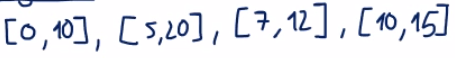

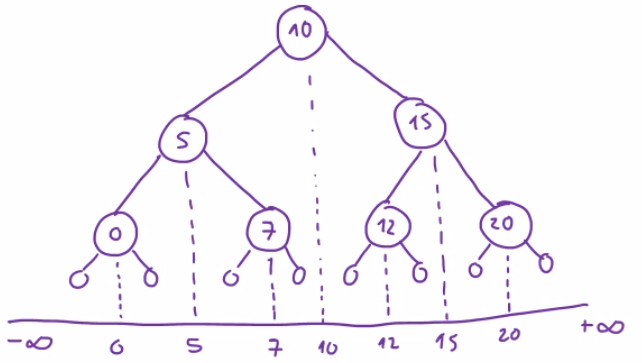

In [14]:
S = [[0, 10], [5, 20], [7, 12], [10, 15]]

it = IntervalTree(S, True)

def dfs(node):
    print(f'Node key: {str(node.key).ljust(4)} \tparent: {str(node.parent.key if node.parent else None).ljust(4)} \tintervals: {node.st.get_all_spans()}')
    if node.left:
        dfs(node.left)
    if node.right:
        dfs(node.right)

In [15]:
dfs(it.root)

Node key: 10   	parent: None 	intervals: []
Node key: 5    	parent: 10   	intervals: []
Node key: 0    	parent: 5    	intervals: []
Node key: None 	parent: 0    	intervals: []
Node key: None 	parent: 0    	intervals: [[0, 10]]
Node key: 7    	parent: 5    	intervals: [[0, 10], [5, 20]]
Node key: None 	parent: 7    	intervals: []
Node key: None 	parent: 7    	intervals: [[7, 12]]
Node key: 15   	parent: 10   	intervals: []
Node key: 12   	parent: 15   	intervals: [[5, 20], [10, 15]]
Node key: None 	parent: 12   	intervals: [[7, 12]]
Node key: None 	parent: 12   	intervals: []
Node key: 20   	parent: 15   	intervals: []
Node key: None 	parent: 20   	intervals: [[5, 20]]
Node key: None 	parent: 20   	intervals: []


In [16]:
print('inserted?', it.insert([0, 10]))
dfs(it.root)

inserted? False
Node key: 10   	parent: None 	intervals: []
Node key: 5    	parent: 10   	intervals: []
Node key: 0    	parent: 5    	intervals: []
Node key: None 	parent: 0    	intervals: []
Node key: None 	parent: 0    	intervals: [[0, 10]]
Node key: 7    	parent: 5    	intervals: [[0, 10], [5, 20]]
Node key: None 	parent: 7    	intervals: []
Node key: None 	parent: 7    	intervals: [[7, 12]]
Node key: 15   	parent: 10   	intervals: []
Node key: 12   	parent: 15   	intervals: [[5, 20], [10, 15]]
Node key: None 	parent: 12   	intervals: [[7, 12]]
Node key: None 	parent: 12   	intervals: []
Node key: 20   	parent: 15   	intervals: []
Node key: None 	parent: 20   	intervals: [[5, 20]]
Node key: None 	parent: 20   	intervals: []


##### Debug:

In [17]:
st = SpansTree()
for span in [[0, 10], [5, 20], [7, 12], [10, 15]]: print('Span:', span, 'Inserted?', st.insert(span))
for span in [[0, 10], [5, 20], [7, 12], [10, 15]]: print('Span:', span, 'Inserted?', st.insert(span))

Span: [0, 10] Inserted? True
Span: [5, 20] Inserted? True
Span: [7, 12] Inserted? True
Span: [10, 15] Inserted? True
Span: [0, 10] Inserted? False
Span: [5, 20] Inserted? False
Span: [7, 12] Inserted? False
Span: [10, 15] Inserted? False


In [18]:
print('Inserted?', st.insert([0, 11]))
print('Inserted?', st.insert([0, 12]))
print('Inserted?', st.insert([5, 6]))

Inserted? True
Inserted? True
Inserted? True


In [19]:
print('Includes?:', st.includes([0, 11]))
print('Includes?:', st.includes([10, 15]))
print('Includes?:', st.includes([0, 5]))

Includes?: True
Includes?: True
Includes?: False


In [20]:
print('Removed?:', st.remove([0, 11]))
print('Removed?:', st.remove([0, 11]))

Removed?: True
Removed?: False


# Problem sumy podprzedziałów
### (Omawiany pod koniec trzeciego nagrania)

### Złożoność

###### Obliczeniowa
$ O(n) $ - budowanie drzewa przedziałowego (tym razem nie sortujemy nic), <br>
$ O(log(n)) $ - znajdowanie sumy podprzedziału, <br>
$ O(log(n)) $ - modyfikacja pojedynczej wartości z przedziału (konieczne jest naprawienie sum w odpowiednich węzłach w czasie $ O(log(n)) $),
###### Pamięciowa
$ O(n) $ - w drzewie znajdzie się maksymalnie $ 2 \cdot n $ elementów - na każdym poziomie wyżej $ 2 $ razy mniej niż na poprzednim, a na ostatnim będzie dokładnie $ n $ elementów, gdzie $ n $ - liczba wartości w całym przedziale (otrzymujemy więc złożoność $ O(2 \cdot n) = O(n) $)

### Implementacja

In [21]:
class SegmentTree:
    def __init__(self, values):
        self.n = len(values)
        self.tree = self._create_tree(values)
        
    def __repr__(self):
        return f'SegmentTree({self.tree[self.n:]})'
        
    def update(self, idx, value):
        i = self.n + idx
        diff = value - self.tree[i]
        # Update all parents sums
        while i: # Root has 1 index so we can loop till an index is non-zero
            self.tree[i] += diff
            i //= 2  # Move to the parent's node
        
    def get_sum(self, a: 'first number index', b: 'last number index'):
        total = 0
        
        def recur(idx=1, i=0, j=self.n-1):
            if a <= i and j <= b:
                nonlocal total
                total += self.tree[idx]
            else:
                mid = (i + j) // 2
                if mid < a:
                    recur(2 * idx + 1, mid + 1, j)
                elif mid >= b:
                    recur(2 * idx, i, mid)
                else:
                    recur(2 * idx + 1, mid + 1, j)
                    recur(2 * idx, i, mid)
                    
        recur()
        return total
        
    def _create_tree(self, values):
        n = len(values)
        arr = [None] * (2 * n)
        
        for i in range(n):
            arr[n + i] = values[i]
            
        for i in range(n - 1, 0, -1):
            arr[i] = arr[2 * i] + arr[2 * i + 1]
            
        return arr

###### Kilka testów

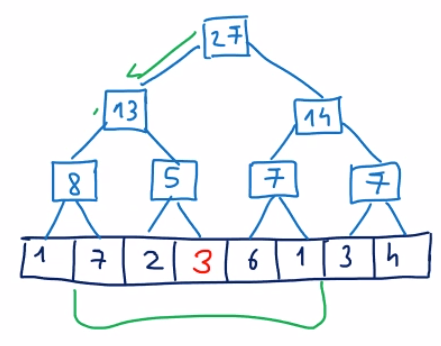

In [22]:
A = [1, 7, 2, 3, 6, 1, 3, 4]

st = SegmentTree(A)
print(st.tree)

[None, 27, 13, 14, 8, 5, 7, 7, 1, 7, 2, 3, 6, 1, 3, 4]


In [23]:
print(st.get_sum(2, 5))

12


In [24]:
print(st.get_sum(5, 5))

1


In [25]:
# Możemy również dać sporo za duże i za małe indeksy. Wówczas zostanie zwrócona suma
# całego przedziału lub wszystkich wartości od danej do końca (np. dla (-100, 4) otrzymamy sumę
# liczb z indeksów 0, 1, 2, 3, 4)
print(st.get_sum(-100, 4))

19


In [26]:
print(st.get_sum(1, 5))

19


In [27]:
st

SegmentTree([1, 7, 2, 3, 6, 1, 3, 4])

In [28]:
st.update(2, -6)
print(st.tree)
st.update(7, 20)
print(st.tree)
st.update(0, -11)
print(st)
print(st.tree)

[None, 19, 5, 14, 8, -3, 7, 7, 1, 7, -6, 3, 6, 1, 3, 4]
[None, 35, 5, 30, 8, -3, 7, 23, 1, 7, -6, 3, 6, 1, 3, 20]
SegmentTree([-11, 7, -6, 3, 6, 1, 3, 20])
[None, 23, -7, 30, -4, -3, 7, 23, -11, 7, -6, 3, 6, 1, 3, 20]


In [29]:
print(st.get_sum(0, 3))

-7
